# Introduction

### What is fake news?

“Fake news, [...] is a form of news consisting of deliberate disinformation or hoaxes spread via traditional news media (print and broadcast) or online social media.” (Wikipedia)

To be honest about Fake News:  it’s nothing new.  “Dirty tricks” to confuse and persuade have been around for millennia. But with the rise of the internet and social media in particular, it became pretty easy to spread fake news. Fake News can be classified in three different categories:

    - Misinformation, defective information or mistakes
    - Disinformation, such as hoaxes,
    - Malinformation and stories intended to damage institutions and individuals


### Why is fake news so prevalent?

[MIT](https://science.sciencemag.org/content/359/6380/1146) researchers found fake news spreads faster than truth!

According to the authors the reason for is that humans have an instinctive desire to be in a group; a desire to belong. We’re wired to react emotionally, not rationally.  We find comfort in similarity and alert to things out of the ordinary.  So we're easily distracted by the unusual, unique or unexpected. And angered when threatened.

Moreover there are three findings of a [study](http://eprints.lincoln.ac.uk/id/eprint/30978/1/briton%20-%20henkel.pdf) of Lincoln University in 2019:

    - Misinformation isn’t just about facts, it’s about stories
    - When fake headlines are repeated, people believe them more
    - False rumors don’t just repeat themselves; they evolve and get stronger


### What to do about it?

Easiest way to countering the problem is through education like [Finnland](https://www.weforum.org/agenda/2019/05/how-finland-is-fighting-fake-news-in-the-classroom/) does. Another way is to put pressure on the companies to prevent or delete fake news content. 
In January, [Germany’s 2017 Network Enforcement Act](https://www.article19.org/wp-content/uploads/2017/09/170901-Legal-Analysis-German-NetzDG-Act.pdf) came into effect, requiring social media platforms to remove and block ‘fake news’, potentially hate-inciting content. and other illegal content prohibited by the Criminal Code, within 24 hours of being notified of the same, with violations resulting in a fine of up to 50 million euros. 

But how can to secure that no fake news spread through the internet? 
A pretty obviously solution is a machine learning model which can ddistinguish between fake news and non-fake news content. Let's give it a try!


## Data

The primary data for the project comes from the facebook page of digital media [BuzzFeed](https://www.buzzfeed.com/) and can be downloaded [here](https://github.com/BuzzFeedNews/2016-10-facebook-fact-check/tree/master/data)  It provides 1469 articles of 9 publishers in a week close to the US elections 2016 and are fact-checked by professional journalists at BuzzFeed.

## Libary import

In [350]:
reset -fs

In [351]:
%matplotlib inline
RSEED = 42
 
# Base Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import percentile
import seaborn as sns
sns.set_style("darkgrid")
from wordcloud import WordCloud
import multiprocessing
from time import time


# Modeling
from xgboost import XGBClassifier

# Pipeline
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as imbPipeline

# NLP
import nltk 
from nltk.corpus import words
from nltk.probability import FreqDist
from nltk.util import ngrams
import re
import unicodedata
from adjustText import adjust_text

# Sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn import feature_extraction, preprocessing, model_selection
from sklearn import feature_selection, metrics, naive_bayes, pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn import manifold
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Gensim
import gensim
import gensim.downloader as gensim_api
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

# Tensorflow
import tensorflow as tf
from tensorflow.keras import models, layers, preprocessing as kprocessing

# Keras
#from keras.utils.vis_utils import pydot
from keras.utils import plot_model
from keras import backend as K

## BERT language model
import transformers
from transformers import TFDistilBertModel




## Load data

In [352]:
data = pd.read_csv('BuzzDataFull.csv')

In [353]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1627 entries, 0 to 1626
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   article      1604 non-null   object
 1   author       1143 non-null   object
 2   title        1596 non-null   object
 3   orientation  1627 non-null   object
 4   veracity     1627 non-null   object
 5   portal       1627 non-null   object
dtypes: object(6)
memory usage: 76.4+ KB


In [354]:
data.sample(5)

,article,author,title,orientation,veracity,portal
410,Washington (CNN)A congressman who represents N...,"By Daniella Diaz, CNN",North Carolina congressman: Protesters 'hate w...,mainstream,mostly true,cnn
124,The 2016 election is shaping up to be the weir...,NaN,George Bush Sr. Delivers Ultimate Taunt To Tru...,left,mixture of true and false,addicting-info
365,"(CNN)Even if their preferred candidate wins, a...","By Tom Kludt, CNN","Pew poll: Most voters 'frustrated,' 'disgusted...",mainstream,mostly true,cnn
1181,"If not for the presidency, Bobby Knight is pus...",NaN,Bobby Knight lauds 'Saint Donald' for temperament,mainstream,mostly true,politico
588,"If an October surprise doesn’t defeat Hillary,...",Red1890,Deplorables Can Defeat Hillary,right,no factual content,eagle-rising


In [355]:
# create column and list with length of articles
data['article_len'] = data['article'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
article_len = []
for x in data.article_len:
    article_len.append(len(x.split()))
data['article_len'] = article_len

In [356]:
# descriptive statistics of length of article
data['article_len'].describe()

count    1627.000000
mean      552.351567
std       548.778886
min         1.000000
25%       296.000000
50%       408.000000
75%       600.000000
max      5451.000000
Name: article_len, dtype: float64

In [357]:
sns.set_style("dark")

/home/digga/data_science/data_science_env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


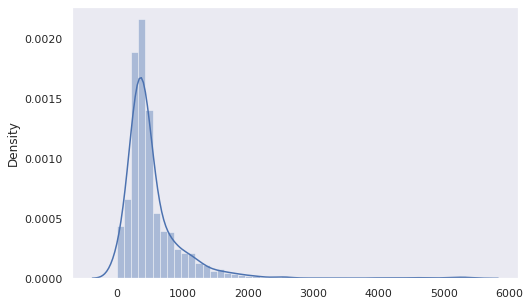

In [358]:
# distribution of article length
plt.figure(figsize=(8,5))
ax = sns.distplot(article_len)

# Data cleaning

- check for missing values
- remove empty article
- check for duplicated article
- combine categories
- remove outlier
- remove very short article

## Missing Values

In [359]:
data.portal.unique()

array(['abc', 'addicting-info', 'cnn', 'eagle-rising', 'freedom-daily',
       'occupy-democrats', 'the-other-98', 'politico', 'right-wing-news'],
      dtype=object)

In [360]:
#check for missing values
data.isnull().sum()

article         23
author         484
title           31
orientation      0
veracity         0
portal           0
article_len      0
dtype: int64

## Empty and duplicated article

In [361]:
# find empty article
data.dropna(subset=['article'], inplace = True)

In [362]:
#find empty article 
empty_list = data[data['article'] == 'The document has moved here.']
print(len(empty_list))
print(empty_list)

14
                          article      author              title orientation  \
562  The document has moved here.  Allen West  Moved Permanently       right   
567  The document has moved here.  Allen West  Moved Permanently       right   
593  The document has moved here.  Allen West  Moved Permanently       right   
597  The document has moved here.  Allen West  Moved Permanently       right   
621  The document has moved here.  Allen West  Moved Permanently       right   
624  The document has moved here.  Allen West  Moved Permanently       right   
648  The document has moved here.  Allen West  Moved Permanently       right   
651  The document has moved here.  Allen West  Moved Permanently       right   
682  The document has moved here.  Allen West  Moved Permanently       right   
686  The document has moved here.  Allen West  Moved Permanently       right   
712  The document has moved here.  Allen West  Moved Permanently       right   
716  The document has moved here.  Al

In [363]:
# drop empty articles
data.drop(data[data['article'] == 'The document has moved here.'].index , inplace=True)
data.shape

(1590, 7)

In [364]:
# find dupilcated article
dupl = data[data.duplicated(['article'])]
print(len(dupl))
print(dupl)

34
                                               article  \
272  (CNN)Former President Bill Clinton sought to a...   
285  Washington (CNN)The National Rifle Association...   
299  United Nations (CNN)President Barack Obama too...   
300  (CNN)Former President George H.W. Bush said Mo...   
313  Washington (CNN)The National Rifle Association...   
316  Washington (CNN)Republicans are preparing for ...   
317  Washington (CNN)The battle over gun rights ret...   
318  Washington (CNN)Senate Minority Leader Harry R...   
319  (CNN)Drawing enormous support from the state's...   
320  United Nations (CNN)President Barack Obama too...   
329  (CNN)Hillary Clinton's campaign manager said W...   
337  New York (CNN)President Barack Obama confronte...   
359  (CNN)Ukrainian President Petro Poroshenko says...   
361  (CNN)Michelle Obama on Tuesday joked about the...   
362  Washington (CNN)With two months to go before E...   
363  (CNN)A group of 375 "concerned" scientists -- ...   
364  Washin

In [450]:
# remove duplicate
data.drop_duplicates(keep='first', inplace=True)
data.shape

(1332, 8)

## Set categories for classification problem

Our dataset provides four categories of news: 

- 'mixture of true and false': '0',
- 'mostly false': '1' '
- 'mostly true': '2' 
- 'no factual content': '3'

For simplification, we transform these four categories in two:

- 'non-fake content: '0'
- 'fake news content: '1'

In [366]:
# encode veracity(prediction) to number
# {'mixture of true and false': '0', 'mostly false': '1', 'mostly true': '2', 'no factual content': '3'}
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
data['veracity'] = LE.fit_transform(data['veracity'])

In [367]:
#rename  = veracity to prediction
data.rename(columns={'veracity': 'prediction'}, inplace = True)

In [368]:
data.prediction.value_counts()

2    1210
0     206
1      80
3      61
Name: prediction, dtype: int64

In [369]:
print(data)

                                                article  \
0     With the Hillary Clinton-Donald Trump debates ...   
1     As police today captured the man wanted for qu...   
2     One day after explosive devices were discovere...   
3     Ahmad Khan Rahami, earlier named a person of i...   
4     Donald Trump's surrogates and leading supporte...   
...                                                 ...   
1622  The shooter responsible for injuring nine peop...   
1623  On the topic of climate change, Hillary Clinto...   
1624  A poll of voters nationwide and focus groups i...   
1625  Three of the Baltimore police officers previou...   
1626  In a powerful statement, a University of Nebra...   

                                                 author  \
0                                           GARY LANGER   
1     Brian Ross Rhonda Schwartz Mike Levine Stephan...   
2                                        ALANA ABRAMSON   
3     EMILY SHAPIRO Aaron Katersky Josh Margolin Mik...

In [370]:
#combine and drop categories of prediciton (drop articles with no factual content)
data.prediction.unique()
data.prediction.value_counts()

2    1210
0     206
1      80
3      61
Name: prediction, dtype: int64

In [371]:
#data.prediction.drop(['3'])
index_2 = data[data['prediction'] == 3].index
data.drop(index_2, inplace=True)

In [372]:
data.shape

(1496, 7)

In [373]:
# combine prediction of mostly & mixture of true and false since we are looking for fake news
# -> dataset with prediction: 0 = mostly True news
#                             1 = mostly Fake News & article with some fake news
data.prediction.replace(0, 1, inplace = True)
data.prediction.replace(2, 0, inplace = True)
data.prediction.value_counts()

0    1210
1     286
Name: prediction, dtype: int64

## Handling outliers

Since we know that the distribution of length of words in the sample isn't Gaussian,
we can't use the standard deviation of the sample as a cut-off 
therefore we use Interquartile Range Method.

In [374]:
# calculate interquartile range
q25, q75 = percentile(data.article_len, 25), percentile(data.article_len, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [idx for idx,x in data.article_len.iteritems() if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in data.article_len if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=307.000, 75th=599.500, IQR=292.500
Identified outliers: 161
Non-outlier observations: 1335


In [375]:
# number of outliers
len(outliers)

161

In [376]:
# remove outliers
data.drop(outliers, inplace=True)

In [377]:
data.shape

(1335, 7)

In [378]:
#find too short article (=less than 42 words)
short = data[data['article_len'] < 42].index
short

Int64Index([57, 262, 560], dtype='int64')

In [379]:
# drop too short article 
data.drop(short, inplace=True)

# Exploratory Data Analysis

At this point I will take a look through the data to discover patterns in the data, form hypotheses, and gather insights. Additionally, I am going to display key information in a visually appealing graphs for better understanding.

## Fake News and reliable news

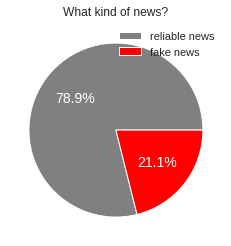

In [380]:
Fig_age_survivial = (data.prediction.value_counts()
                     .plot.pie(autopct='%1.1f%%'
                               ,colors=['grey','red']
                               ,textprops=dict(color="w",size='14')
                               ,label='')
                    )

plt.style.use("seaborn-dark")
plt.title('What kind of news?')
plt.legend(['reliable news','fake news'])
plt.savefig('figures/News_pie.png')

## Article length

In [381]:
#create new dataframe for seaborn graphics
sbdata = data.copy()
sbdata.prediction = sbdata.prediction.map({ 0 : 'True', 1 : 'Fake'})
sbdata.rename(columns={'prediction': 'News'}, inplace = True)

/home/digga/data_science/data_science_env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


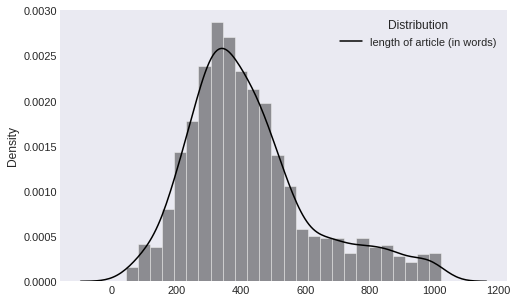

<Figure size 432x288 with 0 Axes>

In [382]:
plt.figure(figsize=(8,5))
ax = sns.distplot(data['article_len'], color="black")
plt.legend(title='Distribution', loc='best', labels=['length of article (in words)'])
ax.set_xlabel('')
plt.show(ax)
plt.savefig('figures/Distribtion.png')

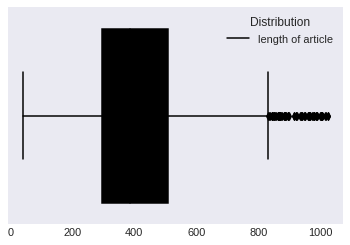

In [383]:
# boxplot 
ax = sns.boxplot(x=sbdata['article_len'], color="black")
ax.set_xlabel('')
plt.legend(title='Distribution', loc='best', labels=['length of article']);
plt.savefig('figures/Boxplot_1.png')

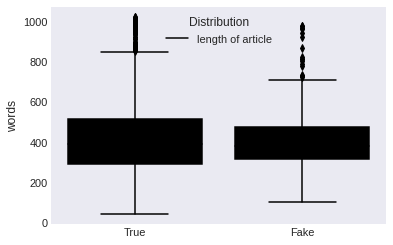

In [384]:
# boxplot by prediction
ax = sns.boxplot(x="News", y='article_len', data=sbdata, color="black")
ax.set_ylabel('words')
ax.set_xlabel('')
plt.legend(title='Distribution', loc='best', labels=['length of article'])
plt.savefig('figures/Boxplot_2.png')

In [385]:
data.shape

(1332, 7)

## Political orientation

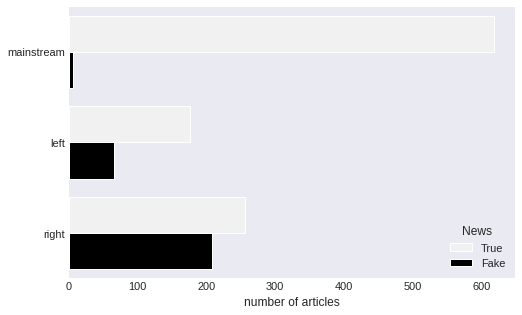

In [386]:
f, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(y="orientation", hue="News", data=sbdata, color="black")
ax.set_ylabel('')
ax.set_xlabel('number of articles')
plt.savefig('figures/orientation.png')

In [387]:
print(len(sbdata.loc[(sbdata['orientation'] == 'mainstream') & (sbdata['News'] == 'True')]))
print(len(sbdata.loc[(sbdata['orientation'] == 'mainstream') & (sbdata['News'] == 'Fake')]))
print(len(sbdata.loc[(sbdata['orientation'] == 'right') & (sbdata['News'] == 'True')]))
print(len(sbdata.loc[(sbdata['orientation'] == 'right') & (sbdata['News'] == 'Fake')]))
print(len(sbdata.loc[(sbdata['orientation'] == 'left') & (sbdata['News'] == 'True')]))
print(len(sbdata.loc[(sbdata['orientation'] == 'left') & (sbdata['News'] == 'Fake')]))

618
7
256
208
177
66


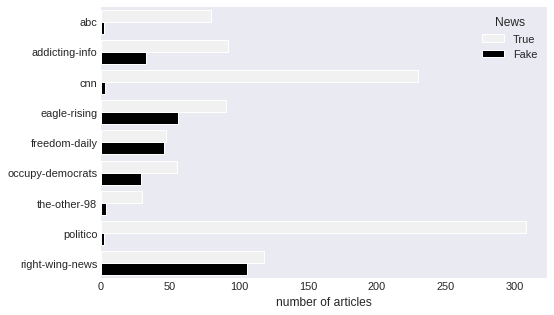

In [388]:
f, ax = plt.subplots(figsize=(8, 5));
sns.countplot(y="portal", hue="News", data=sbdata, color="black")
ax.set_ylabel('')
ax.set_xlabel('number of articles')
plt.savefig('figures/news_source.png')

# Preprocessing

- remove punctuations and set lowercase
- tokenization
- lemmatization
- remove stopwords, URL's, twitter names

In [389]:
print(data.shape)

(1332, 7)


In [390]:
text = data['article']
label = data['prediction']

In [391]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1332 entries, 1 to 1626
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   article      1332 non-null   object
 1   author       972 non-null    object
 2   title        1319 non-null   object
 3   orientation  1332 non-null   object
 4   prediction   1332 non-null   int64 
 5   portal       1332 non-null   object
 6   article_len  1332 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 83.2+ KB


In [392]:
print(data.article[126])

Guess who George H.W. Bush is voting for? He lost to Bill Clinton in 1992, and his son is George W. Bush. Yet it seems that the elder Bush finds Trump so distasteful a candidate that heâs actually going to cast his vote for Hillary Clinton. According to Bush Sr. had originally planned on keeping quiet about this election. Considering the fact that heâs a Republican, and therefore expected to weigh in on the side of the Republicansâ chosen candidate, this is actually pretty major. But it wasnât Bush himself who revealed his vote. It was Kathleen Kennedy Townsendâdaughter of the late Robert Kennedyâwho let this particular interesting tidbit slip: âOn Monday, Townsend posted a picture on her Facebook page shaking hands next to the former president and this caption: âThe President told me heâs voting for Hillary!!'â She stood by that later on when talking to According to her, George H.W. Bush would rather vote for his former rival and successorâs wife than the god-awf

In [393]:
# define stopwords (commonly used words which search engine has been programmed to ignore)
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords.append(['hi', 'said'])
print(lst_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

preprocessing includes:



In [394]:
# code for preprocessing inluding lemmatization

def preprocess_text_lemm(text, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
    
    ## remove URL
    text = re.sub(r'http\S+', '', text)
    
    ## remove twitter
    text = re.sub('@[^\s]+','', text)
        
    # lemmatization
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [395]:
## save preprocessed text
data["text"] = data["article"].apply(lambda x: 
          preprocess_text_lemm(x, flg_lemm=True, lst_stopwords=lst_stopwords))

In [396]:
print(data.head())
print(data.shape)

                                             article  \
1  As police today captured the man wanted for qu...   
2  One day after explosive devices were discovere...   
4  Donald Trump's surrogates and leading supporte...   
5  One woman was killed and several children were...   
6  A Syrian human rights group said today that at...   

                                              author  \
1  Brian Ross Rhonda Schwartz Mike Levine Stephan...   
2                                     ALANA ABRAMSON   
4                                      Candace Smith   
5                                         Lena Masri   
6                 Elizabeth McLaughlin Ben Gittleson   

                                               title orientation  prediction  \
1  Details Emerge About NYC Bomb Suspect Ahmad Kh...  mainstream           0   
2  Donald Trump Repeats Calls for Police Profilin...  mainstream           0   
4  Trump Surrogates Push Narrative That Clinton S...  mainstream           0   
5  1 W

# Predictive Modeling

### Split train and test data

In [397]:
## split dataset
data_train, data_test = model_selection.train_test_split(data, test_size=0.3)
## get target
y_train = data_train["prediction"].values
y_test = data_test["prediction"].values

In [398]:
X_l = data['text']
y_l = data['prediction']
X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_l, y_l, test_size=0.3, random_state=RSEED)

In [399]:
print(X_l_train.shape)
print(y_l_train.shape)
print(X_l_test.shape)
print(y_l_test.shape)

(932,)
(932,)
(400,)
(400,)


### Word cloud

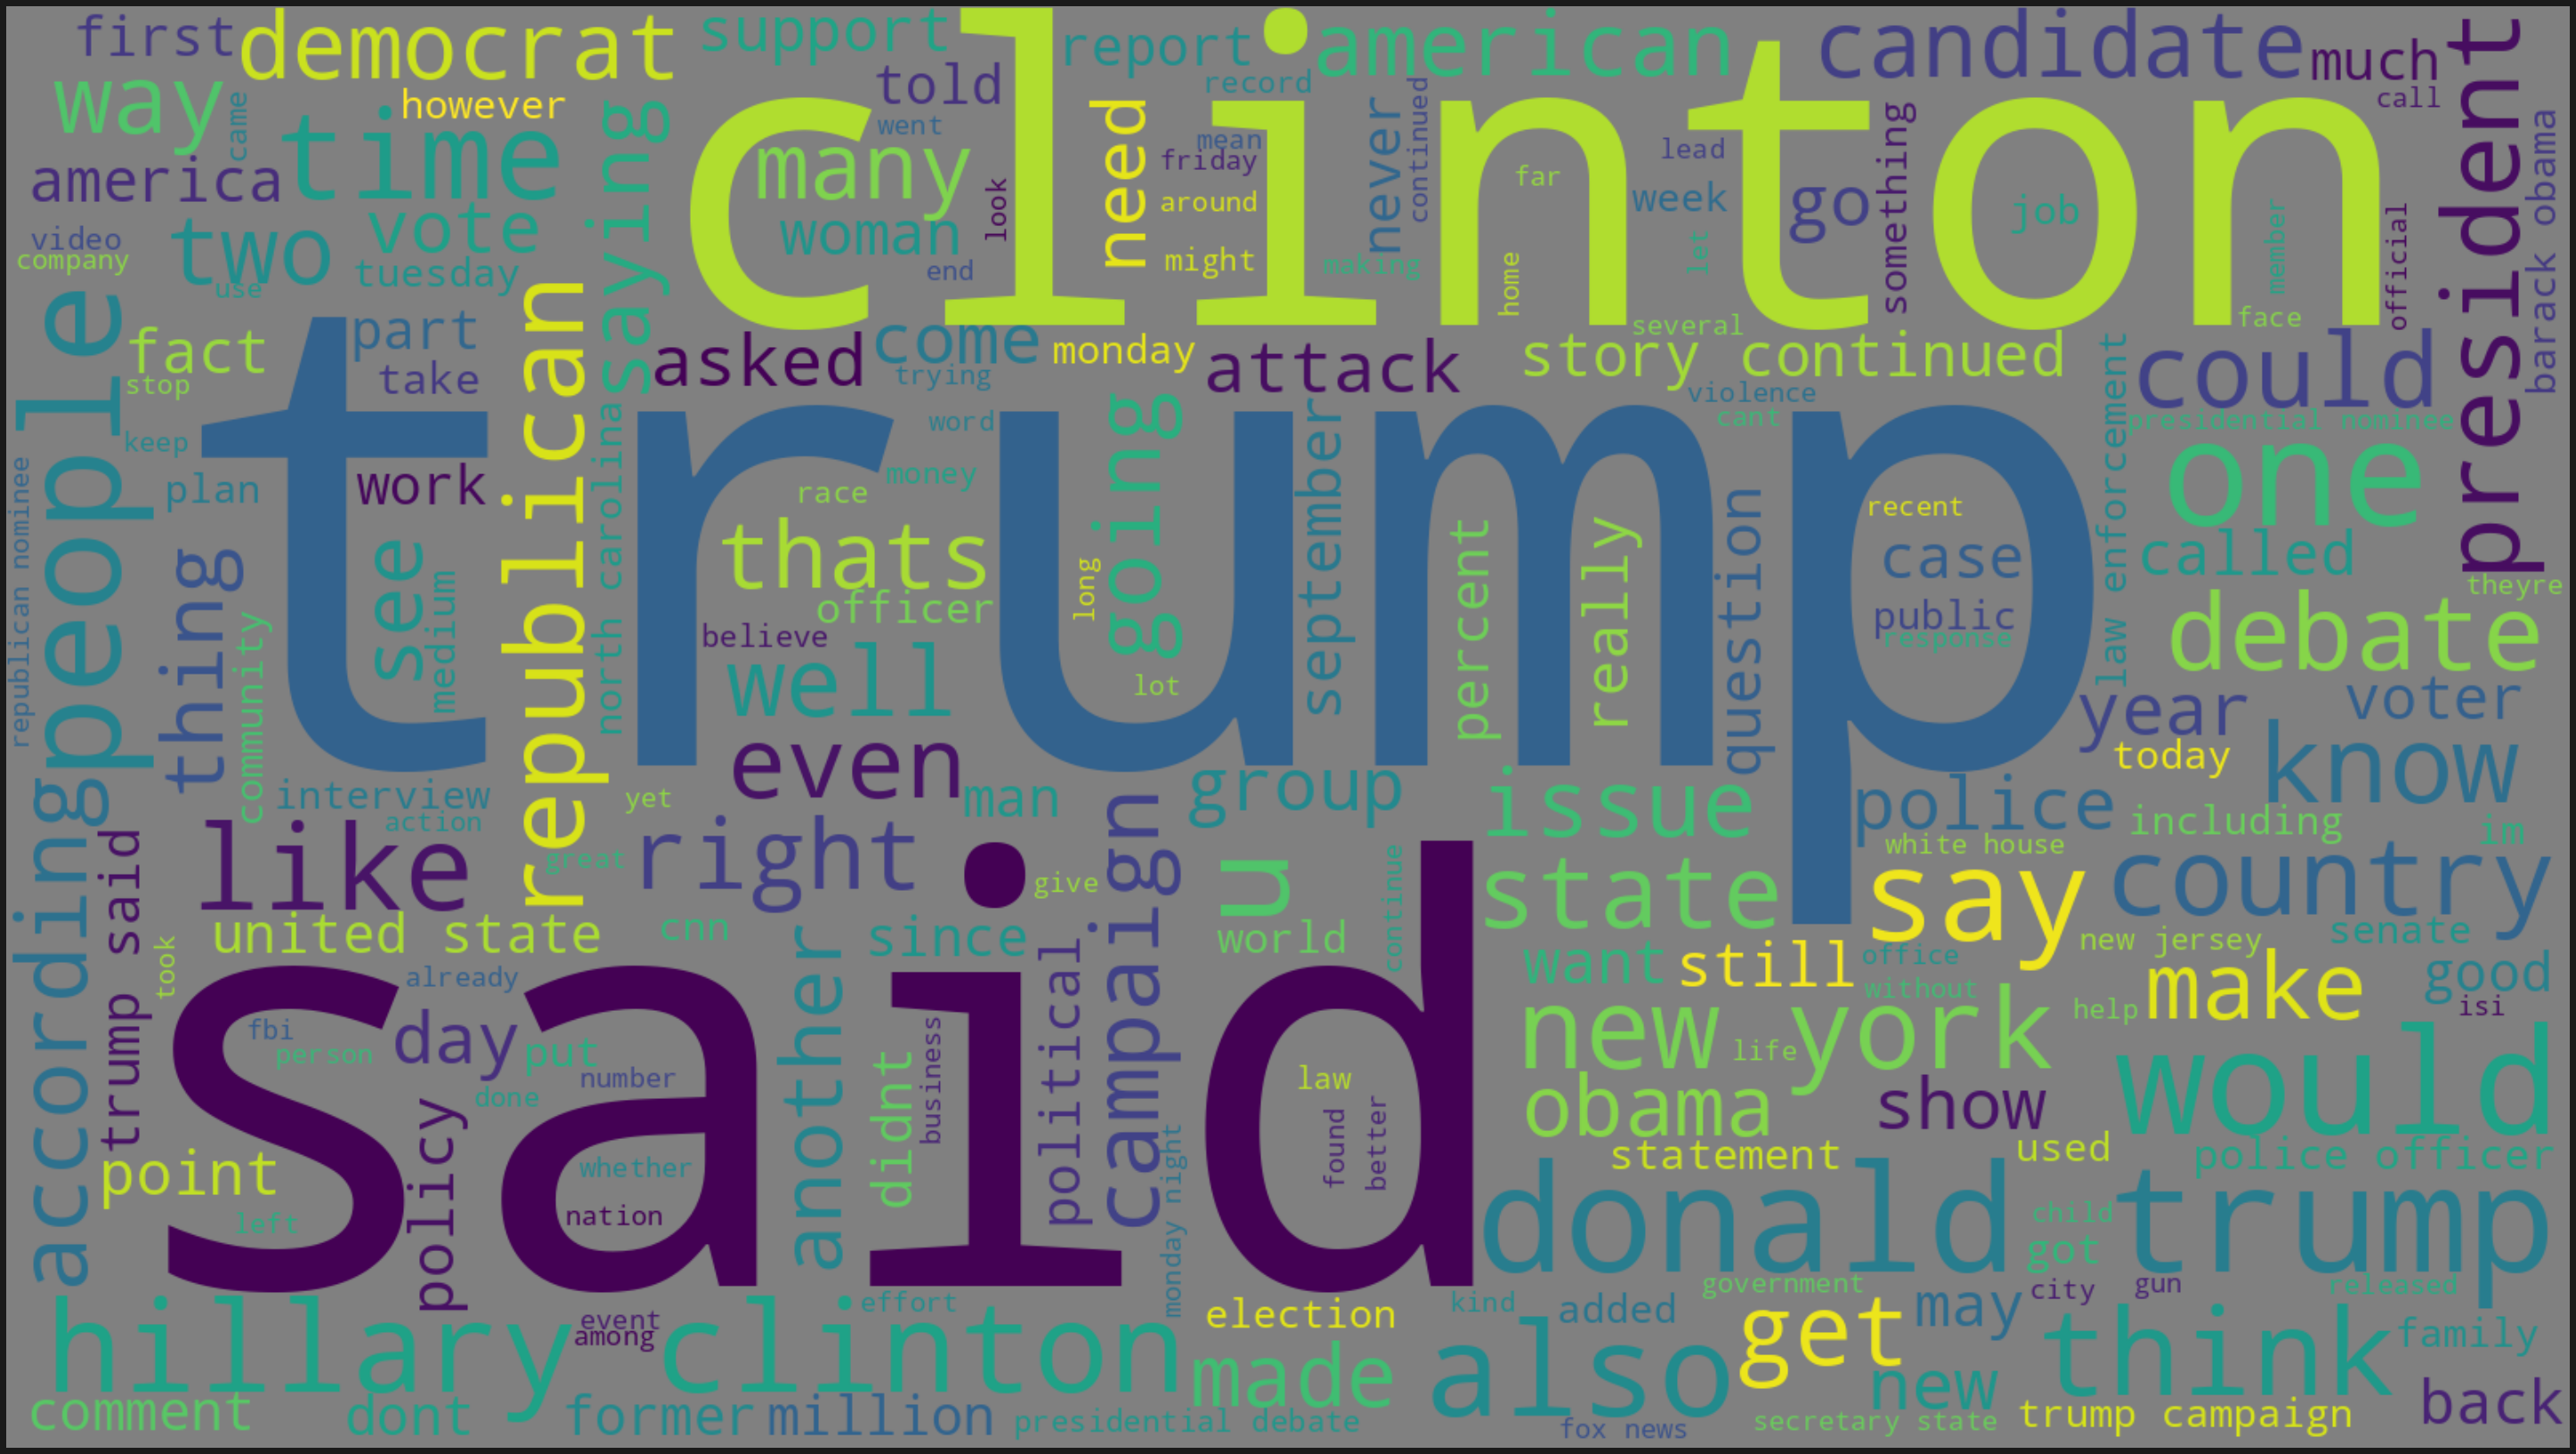

In [400]:
#Word Cloud for data reliable news
lst_true = ''
for news in data[data.prediction==0].text.values:
    lst_true += f" {news}"
wordcloud = WordCloud(
    width = 1600,
    height = 900,
    background_color = 'grey',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(lst_true)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
wordcloud.to_file('figures/Wordcloud_true.png')

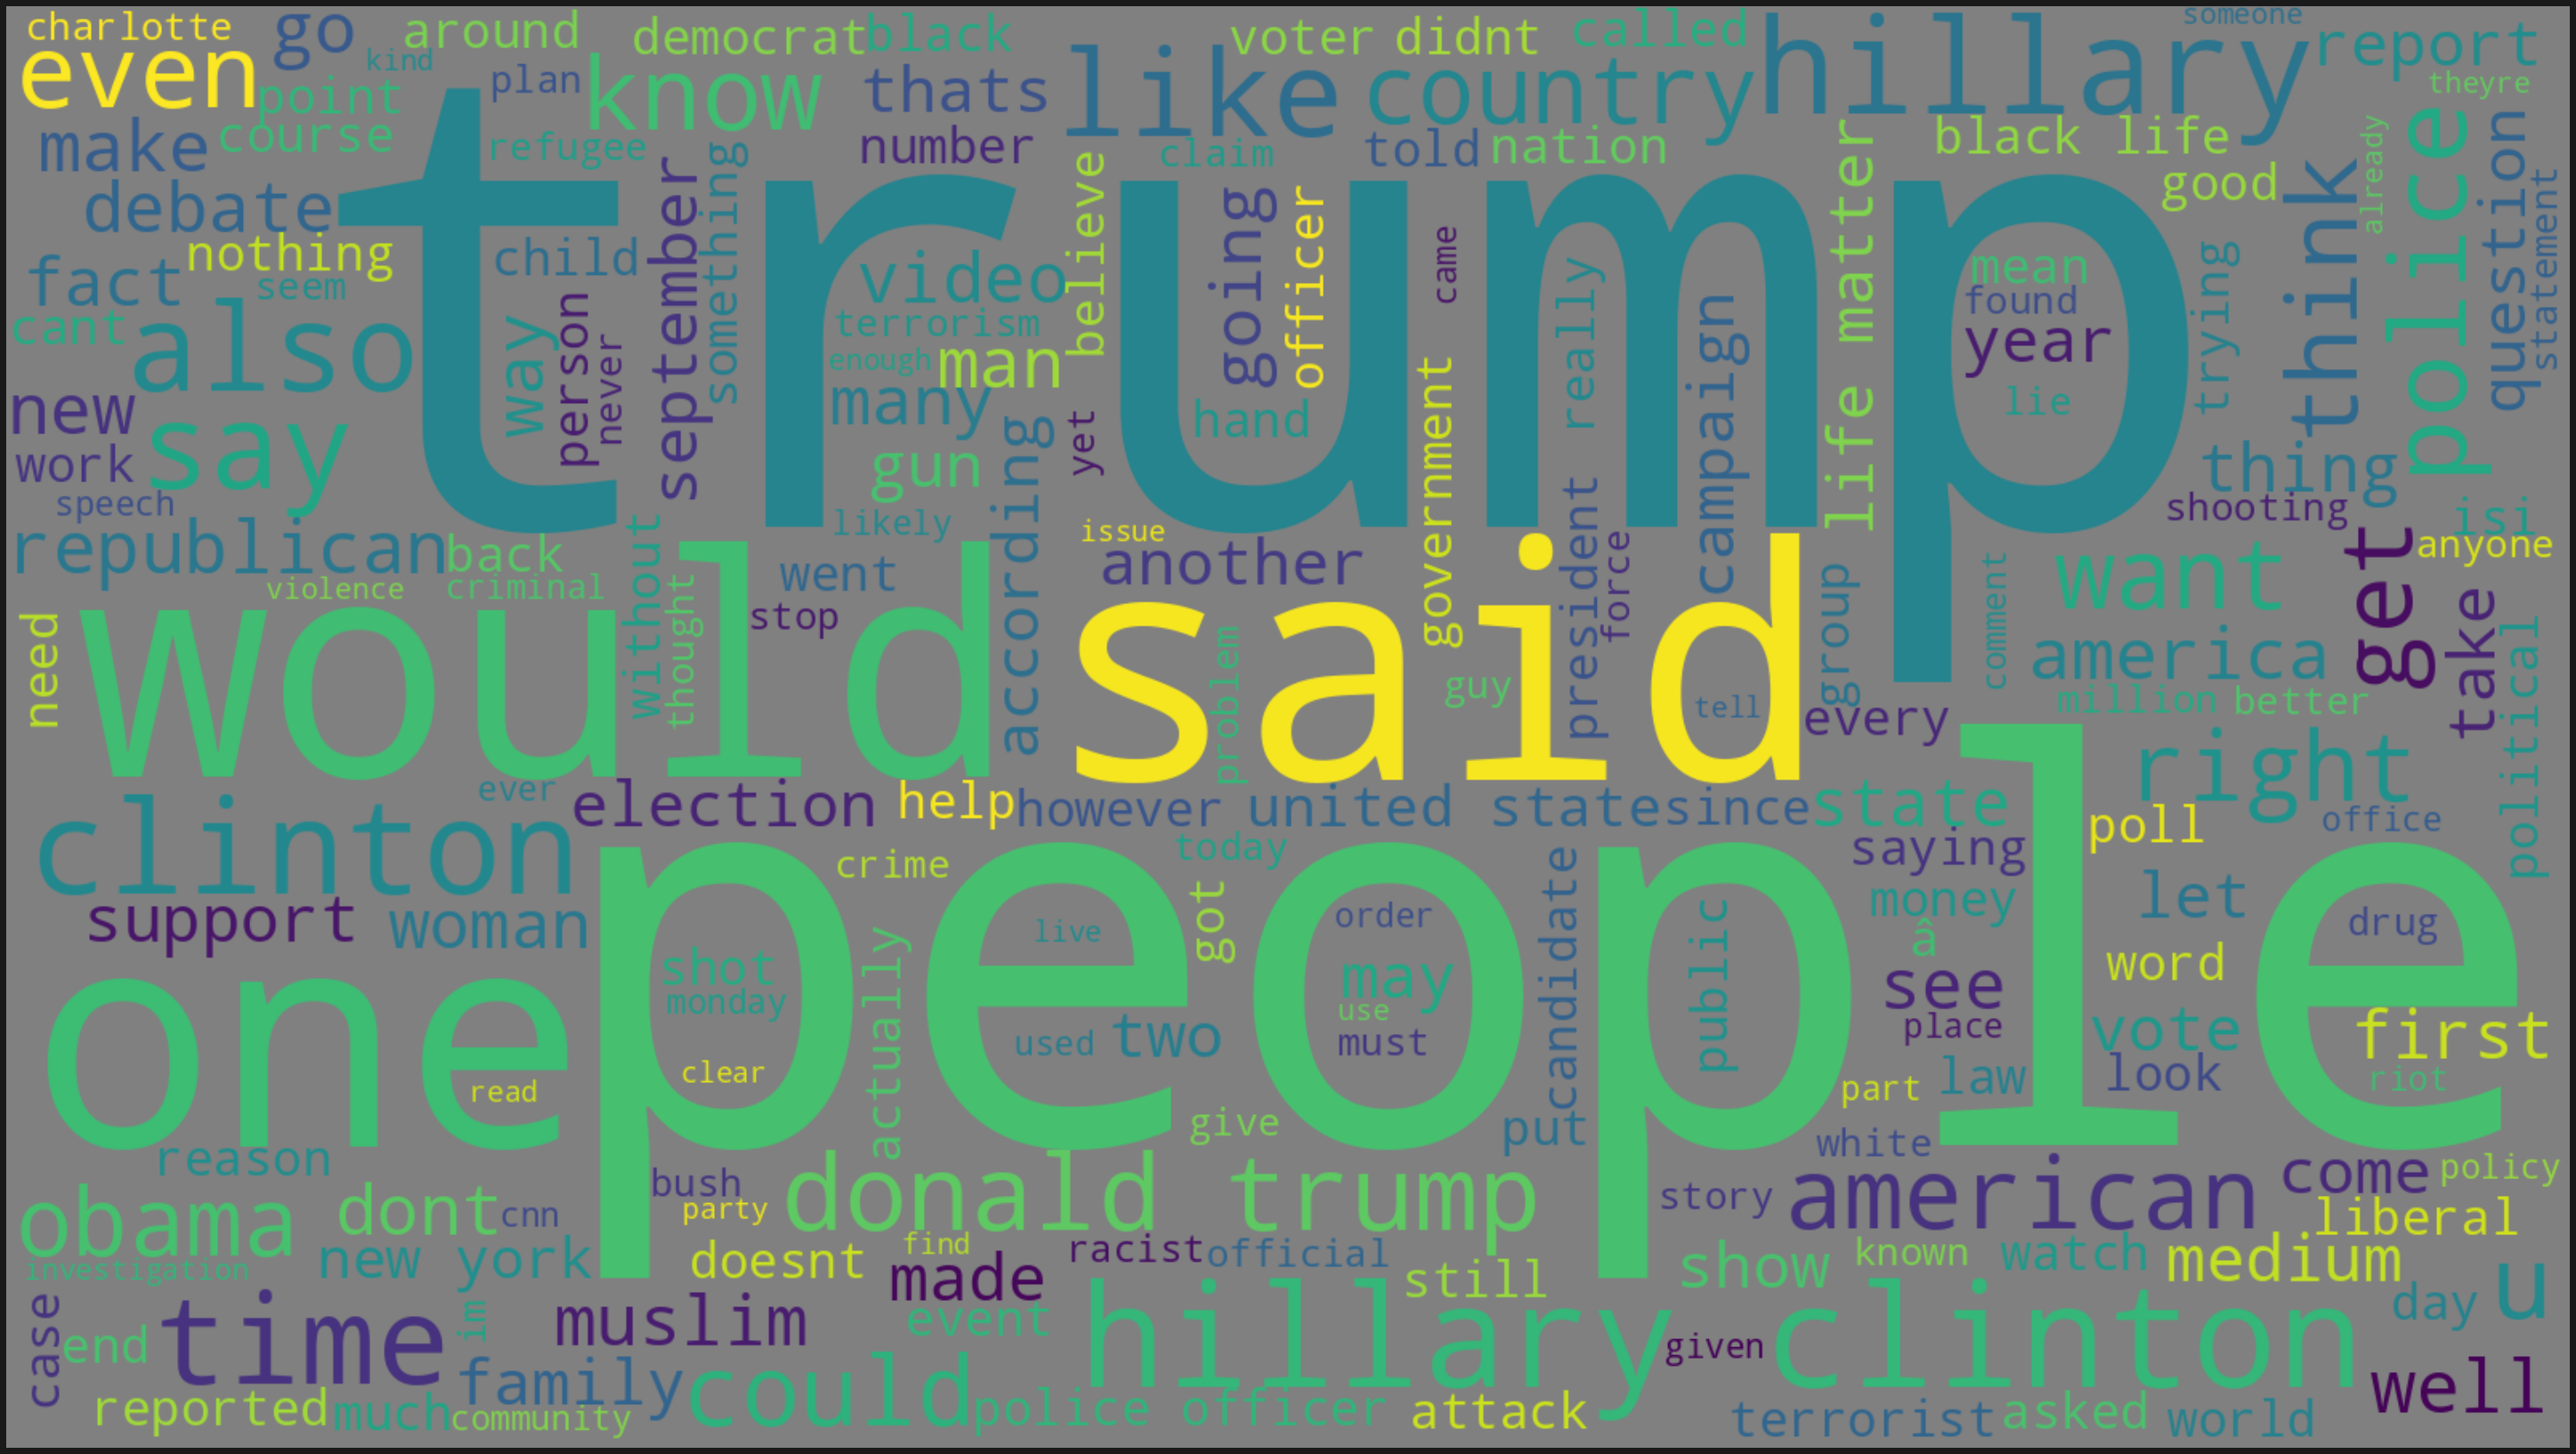

In [401]:
#Word Cloud for data fake news
lst_fake = ''
for news in data[data.prediction==1].text.values:
    lst_fake += f" {news}"
wordcloud = WordCloud(
    width = 1600,
    height = 900,
    background_color = 'grey',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(lst_fake)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
wordcloud.to_file('figures/Wordcloud_fake.png')

## Bag-of-Words with Tf-Idf (Term Frequency - Inverse Document Frequency)

Bag-of-Words model in general builds a vocabulary from a corpus of documents and counts how many times the words appear in each document. Each word in the vocabulary becomes a feature and a document is represented by a vector with the same length of the vocabulary (-> “bag of words”) 

But instead of simple counting, we use the term frequency–inverse document frequency (or Tf–Idf). Basically, the value of a word increases proportionally to count, but it is inversely proportional to the frequency of the word in the corpus.

- Load pre-trained model (Tf-Idf)
- Features Engineering
- Features Selection
- Model Design
- Evaluate

### Load pre-trained model (Tf-Idf)

In [402]:
## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2),lowercase=False)

### Feature engineering

In [403]:
## create vectorizer
corpus = X_l_train
vectorizer.fit(corpus)
X_l_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [404]:
## create vocabulary
dic_vocabulary = vectorizer.vocabulary_
len(dic_vocabulary)

10000

In [405]:
## tokenization
tokenizer = vectorizer.build_tokenizer()
preprocessor = vectorizer.build_preprocessor()
lst_text2tokens = []
for text in corpus:
    lst_tokens = [dic_vocabulary[word] for word in tokenizer(preprocessor(text)) if word in dic_vocabulary]
    lst_text2tokens.append(lst_tokens)
print(len(lst_text2tokens))

932


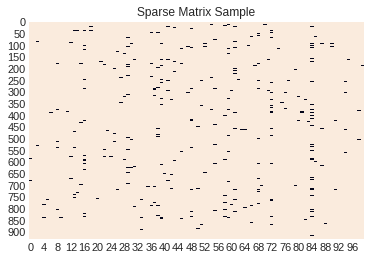

In [406]:
# create sparse matrix
sns.heatmap(X_l_train.todense()[:,np.random.randint(0,X_l_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample');

In [407]:
# test
word = "trump"
dic_vocabulary[word]

9048

### Feature selection

In order to drop some columns and reduce the matrix dimensionality by selecting a subset of relevant variables:

- perform a Chi-Square test to determine whether a feature and the target are independent

- keep only the features with a certain p-value from the Chi-Square test

In [408]:
#Perform feature selection using p-values (keep highly correlated features)
def features_selection(X_train, y_train, X_names, top=None, print_top=10):    
    ## selection
    dtf_features = pd.DataFrame()
    for cat in np.unique(y):
        chi2, p = feature_selection.chi2(X, y==cat)
        dtf_features = dtf_features.append(pd.DataFrame({"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>0.50] #p-value filter
    if top is not None:
        dtf_features = dtf_features.groupby('y')["y","feature","score"].head(top)
    
    ## print
    print("features selection: from", "{:,.0f}".format(len(X_names)), 
          "to", "{:,.0f}".format(len(dtf_features["feature"].unique())))
    print(" ")
    for cat in np.unique(y):
        print("# {}:".format(cat))
        print("  . selected features:", len(dtf_features[dtf_features["y"]==cat]))
        print("  . top features:", ", ".join(dtf_features[dtf_features["y"]==cat]["feature"].values[:print_top]))
        print(" ")
    return dtf_features["feature"].unique().tolist(), dtf_features


In [409]:
#give features with p-value >0.50
y = y_l_train
X_names = vectorizer.get_feature_names()
p_value_limit = 0.50
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_l_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [410]:
dtf_features.loc[dtf_features['y'] == 1].head(10)

,feature,score,y
1856,combetta,0.964684,1
4160,hillary,0.963459,1
2747,drug,0.961331,1
7125,reddit,0.941612,1
7982,sharia,0.926560,1
2099,coughing,0.925443,1
8968,townsend,0.908303,1
3984,haiti,0.905196,1
1097,black,0.897599,1
8874,thug,0.887346,1


In [411]:
print(len(X_names))
print(len(dtf_features))

589
1178


In [412]:
#refit the vectorizer on the corpus by giving this new set of words as input
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_l_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [413]:
len(dic_vocabulary)

589

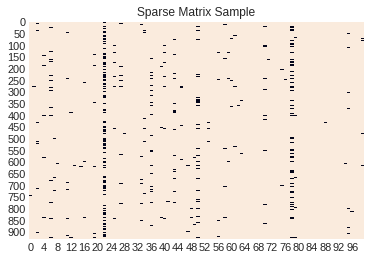

In [414]:
sns.heatmap(X_l_train.todense()[:,np.random.randint(0,X_l_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample');

### Classification

For classification we are using:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBboost
- Adaboost

In [415]:
# define classifiers
classifiers={
        'logreg': LogisticRegression(max_iter=1000, random_state=RSEED,n_jobs=-1),
        'tree': DecisionTreeClassifier(criterion = "gini", max_depth=3,random_state=RSEED),
        'forest': RandomForestClassifier(random_state=RSEED, max_features='sqrt', n_jobs=-1),
        'XGB' : XGBClassifier(seed=RSEED,  n_jobs=-1),
        'AdaBoost' : AdaBoostClassifier(random_state=RSEED)}

In [416]:
results = pd.DataFrame(columns=['Model','Accuracy','Recall','Precision', 'F1'])
i=0
for classifier in classifiers.items():
    # Building a full pipeline with scaler to balance the data and a classifier
    pipe = imbPipeline([
        ('ADASYN', ADASYN(random_state=RSEED)),
        (classifier[0], classifier[1])
    ])
    # Making predictions on the training set using cross validation as well as calculating the probabilities 
    y_l_train_predicted = cross_val_predict(pipe, X_l_train, y_l_train.values.ravel(), cv=5, verbose=5)
    # Calculating the accuracy for Classifier
    temp = pd.DataFrame({
        'Model': classifier[0],
        'Accuracy': accuracy_score(y_l_train, y_l_train_predicted),
        'Recall' : recall_score(y_l_train, y_l_train_predicted),
        'Precision': precision_score(y_l_train, y_l_train_predicted),
        'F1': f1_score(y_l_train, y_l_train_predicted),
        'ROC-AUC': roc_auc_score(y_l_train, y_l_train_predicted)
    }, index=[i])
    i+=1
    results = pd.concat([results, temp])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

[21:24:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
/home/digga/data_science/data_science_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:24:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
/home/digga/data_science/data_science_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:24:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
/home/digga/data_science/data_science_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:24:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.8s remaining:    0.0s
/home/digga/data_science/data_science_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:24:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


In [417]:
results

,Model,Accuracy,Recall,Precision,F1,ROC-AUC
0,logreg,0.796137,0.816832,0.518868,0.634615,0.803621
1,tree,0.770386,0.524752,0.473214,0.497653,0.681554
2,forest,0.847639,0.396040,0.800000,0.529801,0.684321
3,XGB,0.844421,0.613861,0.649215,0.631043,0.761040
4,AdaBoost,0.797210,0.539604,0.531707,0.535627,0.704049


## Word Embedding with Word2Vec

Word Embedding is the collective name for feature learning techniques where words from the vocabulary are mapped to vectors of real numbers. These vectors are calculated from the probability distribution for each word appearing before or after another.
Word2Vec produces a vector space, typically of several hundred dimensions, with each unique word in the corpus such that words that share common contexts in the corpus are located close to one another in the space

### Common n-grams detectors

Before starting with our embedding model, we create an n-grams model which predicts the most probable word that might follow this sequence

In [418]:
# create clean up function which does normalization, encoding/decoding, lower casing, and lemmatization.
def basic_clean(text):
    
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [419]:
words = basic_clean(''.join(X_l.tolist()))

In [420]:
words[:10]

['police',
 'today',
 'captured',
 'man',
 'wanted',
 'questioning',
 'connection',
 'series',
 'explosive',
 'device']

In [421]:
len(words)

317902

In [422]:
#Bigrams occur the most in the news articles
(pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]

(donald, trump)       989
(hillary, clinton)    848
(new, york)           554
(united, state)       314
(police, officer)     286
(story, continued)    274
(trump, said)         249
(trump, campaign)     237
(north, carolina)     217
(new, jersey)         208
dtype: int64

In [423]:
#Trigrams occur the most in the news articles
(pd.Series(nltk.ngrams(words, 3)).value_counts())[:10]

(black, life, matter)                  147
(new, york, city)                      122
(former, secretary, state)              98
(nominee, donald, trump)                97
(republican, presidential, nominee)     93
(president, barack, obama)              89
(keith, lamont, scott)                  83
(first, presidential, debate)           82
(either, shared, endorsed)              69
(eaglerisingcom, get, daily)            69
dtype: int64

### Visualization

In [424]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:10]

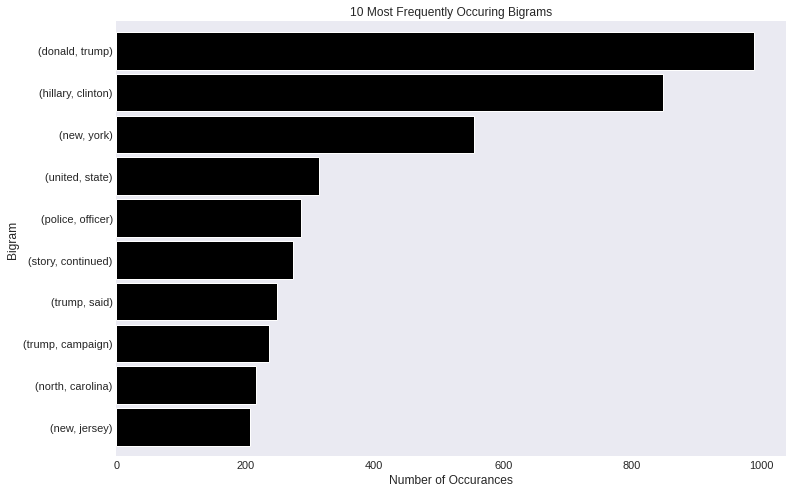

In [425]:
bigrams_series.sort_values().plot.barh(color='black', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances');

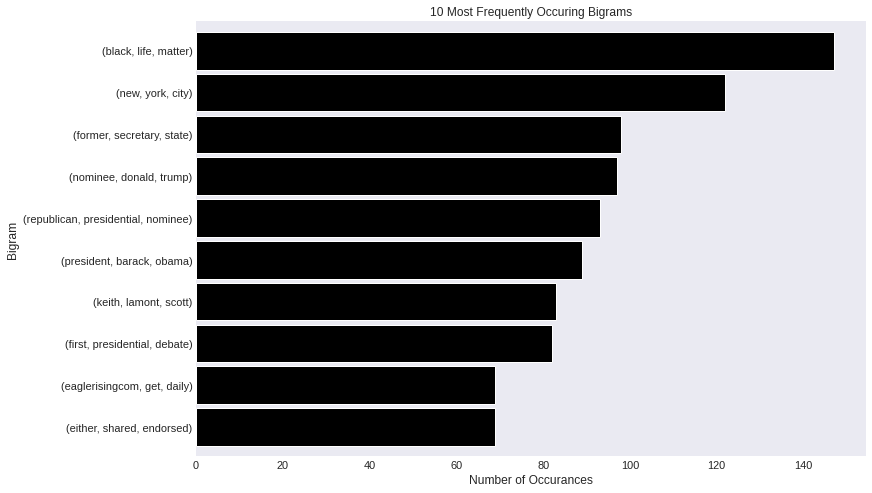

In [426]:
trigrams_series.sort_values().plot.barh(color='black', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances');

### Train Model

In [427]:
# Phrases() takes a list of list of words as input
sent = [row.split() for row in data['text']]

In [428]:
# creates the relevant phrases from the list of sentences
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [429]:
# goal of Phraser() is to cut down memory consumption by discarding model state not strictly needed for the bigram detection task
bigram = Phraser(phrases)

In [430]:
# transform the corpus based on the bigrams detected
sentences = bigram[sent]

In [431]:
# count cpu cores
cores = multiprocessing.cpu_count()

In [432]:
# setup parameters for model training
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [433]:
# builds the vocabulary from a sequence of sentences and thus initialized the model
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))


Time to build vocab: 0.01 mins


In [434]:
# train the model
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.35 mins


In [435]:
print(w2v_model)

Word2Vec(vocab=2752, vector_size=300, alpha=0.03)


In [436]:
#precomputing L2-norms of word weight vectors
#w2v_model.init_sims(replace=True)

### Explore model

In [437]:
# most similar words for 'hate'
w2v_model.wv.most_similar(positive=["hate"])


[('teaching', 0.9068043828010559),
 ('mad', 0.8984858989715576),
 ('truly', 0.8965917825698853),
 ('nazi', 0.8890393972396851),
 ('everyone', 0.8823402523994446),
 ('feel', 0.8810868263244629),
 ('hatred', 0.8789584040641785),
 ('kid', 0.8777108788490295),
 ('life_matter', 0.8740021586418152),
 ('god', 0.8724459409713745)]

In [451]:
# similarities of two words to each other
w2v_model.wv.similarity("black", 'crime')

0.5567072

### Model Visualization

In [438]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
tsne_df = tsne.fit_transform(X_l_train)

/home/digga/data_science/data_science_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


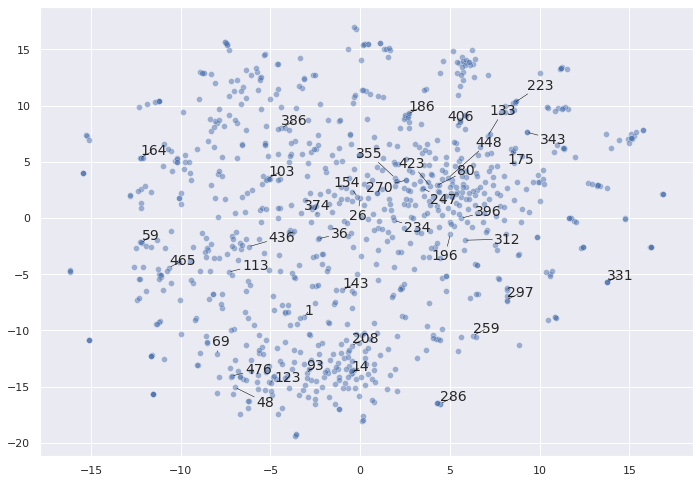

In [439]:
sns.set()# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts

texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], data.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

### Feature Engineering

From here word vectors can be used in a neural network as weights by following these steps:

- Transform corpus into padded sequences of word ids to get a feature matrix.
- Create an embedding matrix so that the vector of the word with id N is located at the Nth row.
- Build a neural network with an embedding layer that weighs every word in the sequences with the   corresponding vector.

In [440]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(sentences)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(words)
## padding sequence
X_l_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=100, padding="post", truncating="post")

In [441]:
# every text in the corpus is now an id sequence with length 10
print(X_l_train.shape)

(317902, 100)


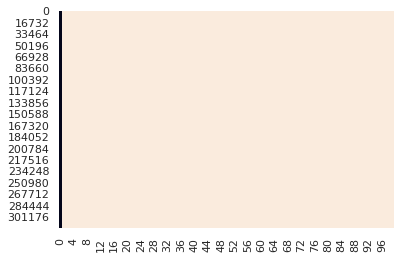

In [442]:
sns.heatmap(X_l_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [443]:
## padding sequence for test data
X_l_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=10,
             padding="post", truncating="post")

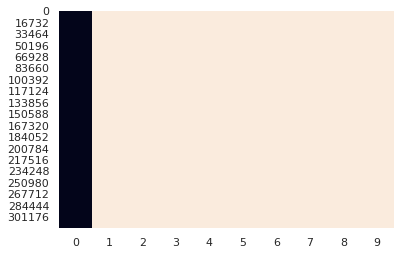

In [444]:
sns.heatmap(X_l_test==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [445]:
#matrix of embedding -> will be used as a weight matrix in the neural network classifier

## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [446]:
word = "trump"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 2 |idx
embeddings[idx]: (300,) |vector


In [447]:
#python -m gensim.scripts.word2vec2tensor -i INPUT_FILE_PATH -o OUTPUT_FILE_PATH

### Model design

In [448]:
### backstopper

#tf.keras.callbacks.EarlyStopping(
#    monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
#    baseline=None, restore_best_weights=False
#)

In [452]:
# build model and set layer
y_l_train = pd.get_dummies(data_train["prediction"], drop_first=False).values

model = models.Sequential([
    layers.Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], weights=[embeddings],
                     input_length=X_l_train.shape[1], trainable=False),
    layers.LSTM(units=X_l_train.shape[1], dropout=0.2),
    layers.Dense(2, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

training = model.fit(x=X_l_train, y=y_l_train, batch_size=8, epochs=10, shuffle=True, verbose=0, validation_split=0.3)
predicted_prob = model.predict(X_l_test)
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_l_train))}
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          6801300   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 6,961,902
Trainable params: 160,602
Non-trainable params: 6,801,300
_________________________________________________________________


ValueError: Data cardinality is ambiguous:
  x sizes: 222531
  y sizes: 932
Make sure all arrays contain the same number of samples.

In [ ]:
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

In [ ]:
utils_plot_keras_training(training)

In [ ]:
#show model 
tf.keras.utils.plot_model(model, show_shapes=True)

## Language Model with BERT

Language model overcomes the biggest limitation of the classic Word Embedding approach: polysemy disambiguation (a word with different meanings) is identified by just one vector

Google’s BERT (Bidirectional Encoder Representations from Transformers, 2018) combines ELMO context embedding and several Transformers, plus it’s bidirectional (which was a big novelty for Transformers). The vector BERT assigns to a word is a function of the entire sentence, therefore, a word can have different vectors based on the contexts

For Fine-tuning the pre-trained model (transfer learning), I use a lighter version of BERT, called [Distil-BERT](https://huggingface.co/transformers/model_doc/distilbert.html)

DistilBERT is a small, fast, cheap and light Transformer model trained by distilling Bert base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of Bert’s performances as measured on the GLUE language understanding benchmark.

In [ ]:
## distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

### Feature Engineering

Please note that I’m using the raw text as corpus

In [ ]:
corpus = data_train['article']
maxlen = 50

## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## generate idx
idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    
## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## feature matrix
X_train = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

In [ ]:
i = 42
print("txt: ", data_train["article"].iloc[0])
print("tokenized:", [tokenizer.convert_ids_to_tokens(idx) for idx in X_train[0][i].tolist()])
print("idx: ", X_train[0][i])
print("mask: ", X_train[1][i])
print("segment: ", X_train[2][i])

In [ ]:
#same for test data
corpus = data_test['article']
maxlen = 50

## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## generate idx
idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    
## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## feature matrix
X_test = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

### Deep learning model with transfer learning

- Summarize the output of BERT into one vector with Average Pooling 
- Add two final Dense layers to predict the probability of each news category

In [ ]:
## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, 
           attention_dropout=0.2)
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), 
                     activation='softmax')(x)
## compile
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
## feature matrix
X_test = [[tf.convert_to_tensor(idx),
           tf.convert_to_tensor(masks)]]
## feature matrix
X_train = [tf.convert_to_tensor(idx),
           tf.convert_to_tensor(masks)]

### Train, test, evaluate model

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])


### COMMING SOON